# CryptoProphet
## Notebook's Goal
> Preprocess data for training

In [1]:
# imports custom packages
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH

# imports official packages
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import pandas as pd
import pickle

# imports text data 
tqdm_notebook.pandas()
tweets_path = LOCAL_PROCESSED_DATA_PATH / 'tweets_with_embeddings_20211013.pkl'
tweets = pd.read_pickle(tweets_path)

# imports price data
prices_path  = LOCAL_PROCESSED_DATA_PATH / 'btc-usd_featurized.pkl'
prices = pd.read_pickle(prices_path)

c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# converts id to string
tweets.id_str = tweets.id_str.astype(str)

# merges datasets
df = tweets.merge(prices, how='outer', left_on='created_at_trunc_h', right_on='date')
df.head(2).T

,0,1
created_at,2021-10-13 14:00:11,2021-10-13 14:56:12
id,1.44829e+18,1.4483e+18
id_str,1448287453043953664,1448301550531530752
full_text,@DocumentingBTC This is good for #bitcoin,REVERSALtoDOWN: $ARCB ArcBest Corporation 📳 Tr...
truncated,False,False
display_text_range,"[16, 41]","[0, 84]"
entities,"{'hashtags': [{'text': 'bitcoin', 'indices': [...","{'hashtags': [], 'symbols': [{'text': 'ARCB', ..."
source,"<a href=""https://mobile.twitter.com"" rel=""nofo...","<a href=""https://dlvrit.com/"" rel=""nofollow"">d..."
in_reply_to_status_id,1.44828e+18,NaN
in_reply_to_status_id_str,1.44828e+18,NaN


<AxesSubplot:>

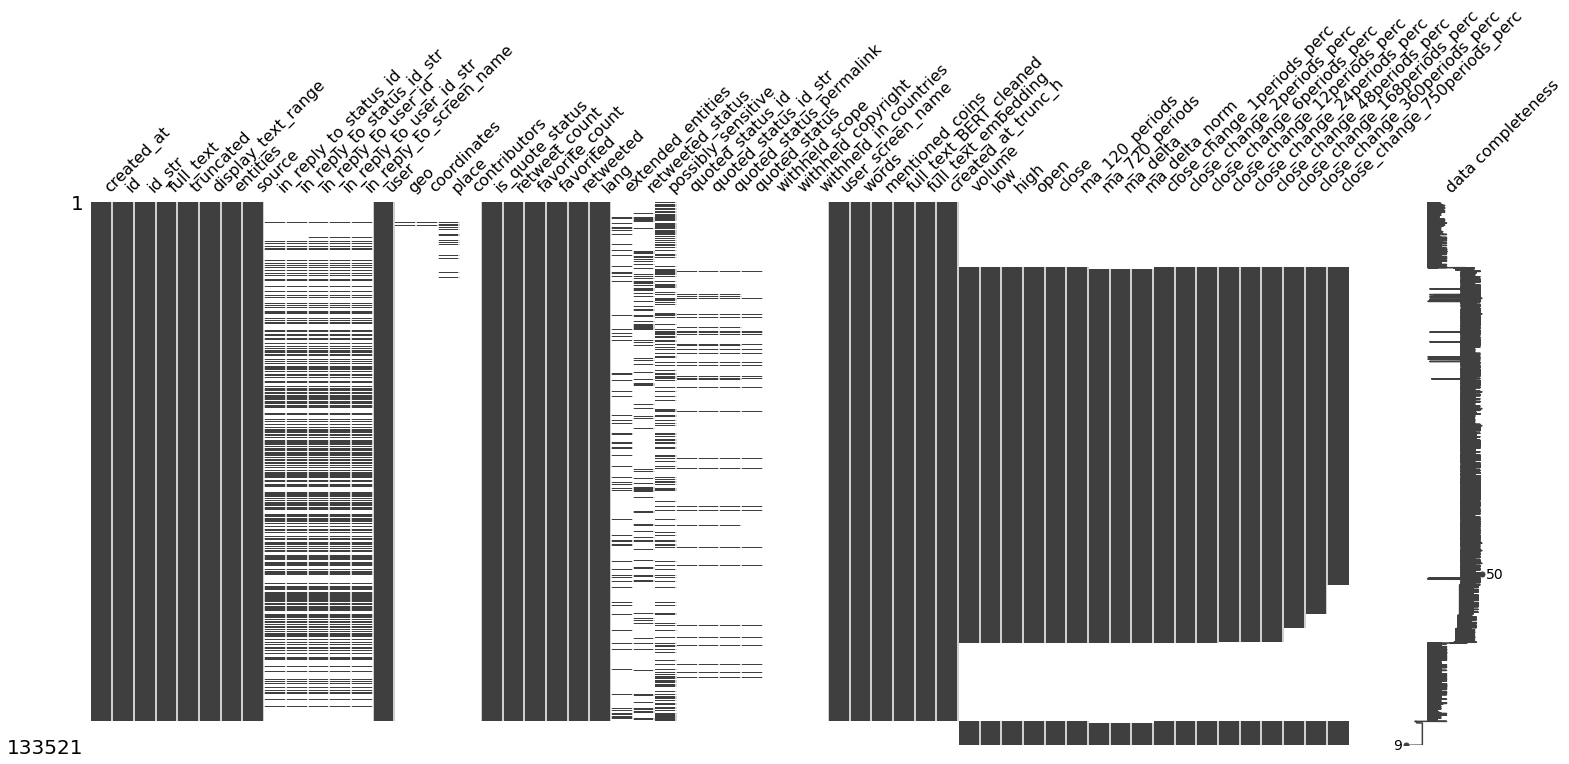

In [5]:
# check missing values visually
%matplotlib inline
msno.matrix(df.sort_values('created_at'), labels=True)

<AxesSubplot:>

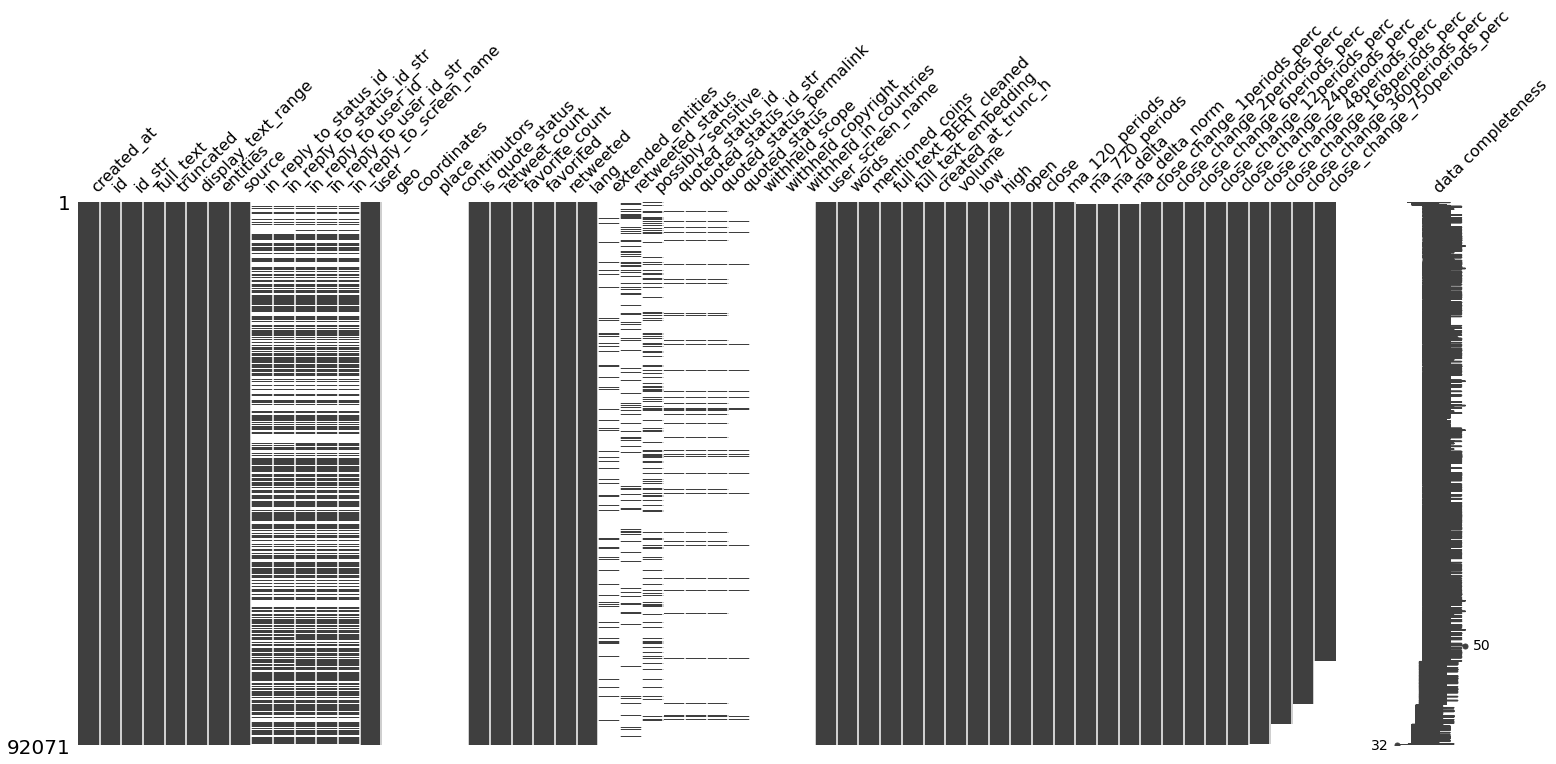

In [7]:
# remove data with empty target variable (close_change_2periods_perc)
mask = df.close_change_1periods_perc.notna() & df.id_str.notna()
df = df[mask].sort_values('created_at')
msno.matrix(df, labels=True)

In [8]:
# encodes user_screen_name
user_le = LabelEncoder() 
df['user_feat'] = user_le.fit_transform(df.user_screen_name)
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', 'wb') as fp:
    pickle.dump(user_le, fp)

In [9]:
# transform mentioned coins to One Hot Encoding columns
rel_coins = ['BTC', 'ETH', 'LTC', 'DOGE',  'USDT', 'ADA']
df['mentioned_coins'] = df.mentioned_coins.apply(lambda x: [c for c in x if c in rel_coins])
coins = df['mentioned_coins'].explode()
df = df.join((pd.crosstab(coins.index, coins)>0).astype(int))
df[rel_coins] = df[rel_coins].fillna(0).astype(int)

In [10]:
# select columns to keep (for train)
cols = ['created_at', 'created_at_trunc_h', 'id_str', 'full_text',
        'retweet_count', 'favorite_count', 'user_screen_name', 'user_feat',
         'BTC', 'DOGE', 'ETH', 'LTC', 'USDT', 'ADA',
        'volume', 'close', 'ma_120_periods', 'ma_720_periods',
        'close_change_1periods_perc', 'close_change_2periods_perc', 'close_change_6periods_perc',
        'close_change_12periods_perc', 'close_change_24periods_perc', 'close_change_48periods_perc',
        'close_change_168periods_perc', 'close_change_360periods_perc', 'close_change_750periods_perc',
]

In [11]:
# converts embeddings into columns (features)
embeddings = df.full_text_embedding.progress_apply(pd.Series)

  0%|          | 0/92071 [00:00<?, ?it/s]

<AxesSubplot:>

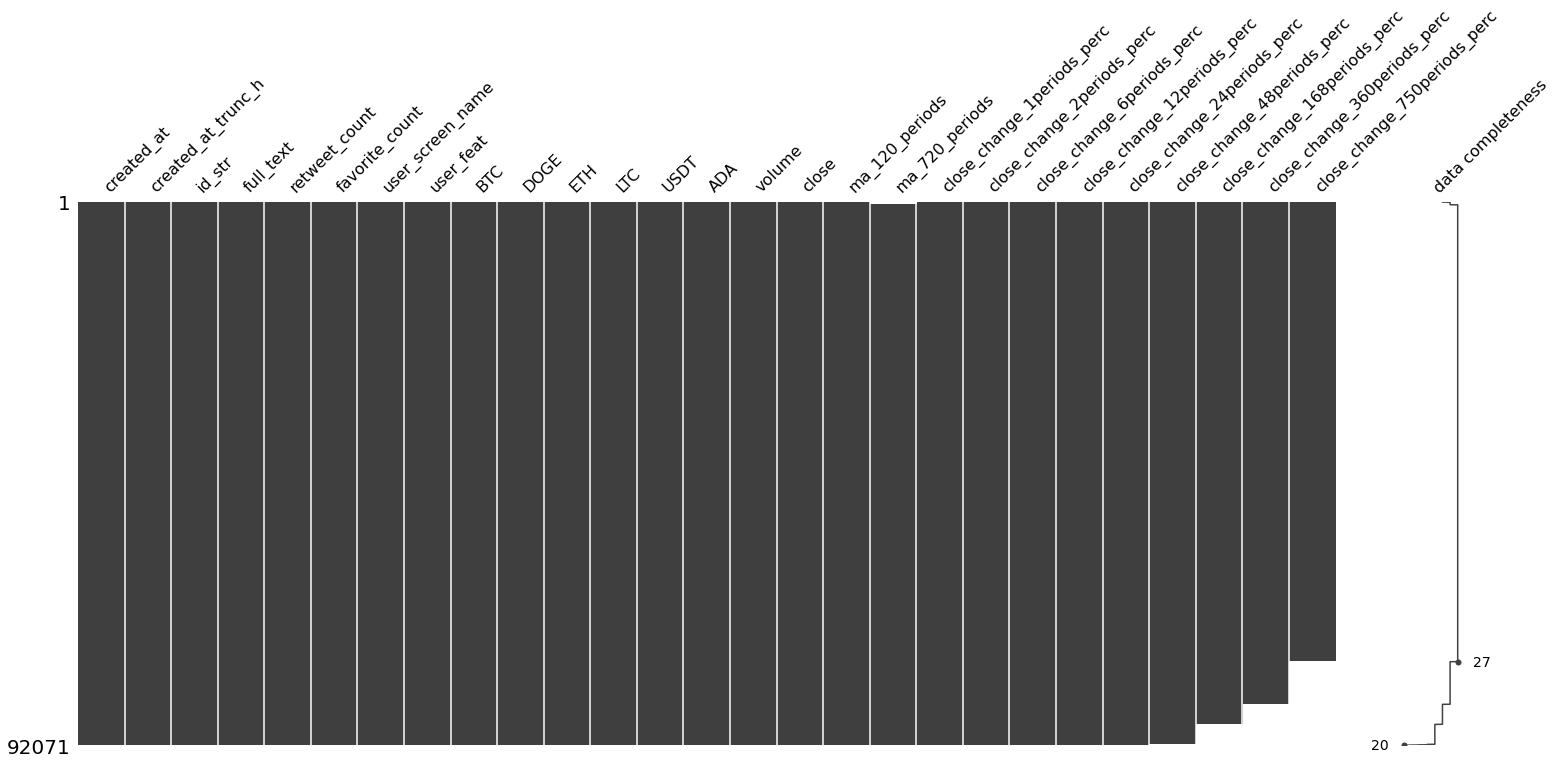

In [12]:
# plots results missing values
msno.matrix(df[cols], labels=True)

In [13]:
# exports data
df[cols].join(embeddings).to_pickle(LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013.pkl')

# Conclusion
> Data properly exported for training